In [ ]:
# importing necessary tools
import datetime
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D

# **turning into tensors**

In [ ]:
train_df = pd.read_csv('/content/Train.csv')
train_df.describe()

Width        Height  ...        Roi.Y2       ClassId
count  39209.000000  39209.000000  ...  39209.000000  39209.000000
mean      50.835880     50.328930  ...     44.728379     15.788390
std       24.306933     23.115423  ...     21.971145     12.013238
min       25.000000     25.000000  ...     20.000000      0.000000
25%       35.000000     35.000000  ...     30.000000      5.000000
50%       43.000000     43.000000  ...     38.000000     12.000000
75%       58.000000     58.000000  ...     52.000000     25.000000
max      243.000000    225.000000  ...    205.000000     42.000000

[8 rows x 7 columns]

In [ ]:
#We will be using only ClassID and Path features, other columns can be ignored.
train_df = train_df.drop(['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2'], axis = 1)
train_df.head()

ClassId                            Path
0       20  Train/20/00020_00000_00000.png
1       20  Train/20/00020_00000_00001.png
2       20  Train/20/00020_00000_00002.png
3       20  Train/20/00020_00000_00003.png
4       20  Train/20/00020_00000_00004.png

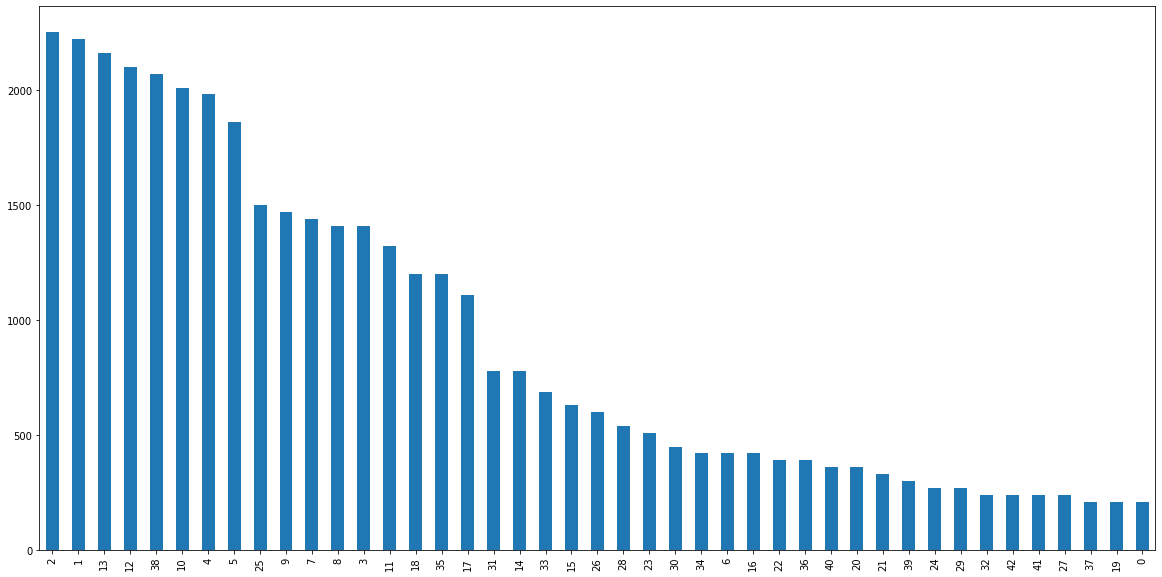

In [ ]:
train_df['ClassId'].value_counts().plot.bar(figsize=(20, 10))
plt.show()


# **Getting images and their labels**

In [ ]:
# Create pathnames from image Id's
filenames = ['/content/' + fname for fname in train_df['Path']]
filenames[:10]

['/content/Train/20/00020_00000_00000.png',
 '/content/Train/20/00020_00000_00001.png',
 '/content/Train/20/00020_00000_00002.png',
 '/content/Train/20/00020_00000_00003.png',
 '/content/Train/20/00020_00000_00004.png',
 '/content/Train/20/00020_00000_00005.png',
 '/content/Train/20/00020_00000_00006.png',
 '/content/Train/20/00020_00000_00007.png',
 '/content/Train/20/00020_00000_00008.png',
 '/content/Train/20/00020_00000_00009.png']

In [ ]:
labels = train_df['ClassId'].to_numpy()
labels

array([20, 20, 20, ..., 42, 42, 42])

In [ ]:

unique_signs = np.unique(labels)
len(unique_signs)

43

In [ ]:
# Converting the labels into one hot encoding 
#A one hot encoding allows the representation of categorical data to be more expressive. 
#Many machine learning algorithms cannot work with categorical data directly. The categories must be converted into numbers.
labels = tf.keras.utils.to_categorical(labels, 43)
labels[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
len(labels)


39209

# **Creating Validation set**

In [ ]:
# Create X & y variables
X = filenames
y = labels

# Splitting our data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)
print("Number of training images: ", len(X_train)),
print("Number of training labels: ", len(y_train)),
print("Number of testing images: ", len(X_val)),
print("Number of testing labels: ", len(y_val))

Number of training images:  31367
Number of training labels:  31367
Number of testing images:  7842
Number of testing labels:  7842


# **Processing image and turning into Tensors**

In [ ]:
IMG_SIZE = 32

def process_image(image_path):
    """
    Takes an image file path and turns the image into a Tensor.
    """
    # Read in an image file
    image = tf.io.read_file(image_path)
    # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
    image = tf.image.decode_png(image, channels=3)
    # Convert the colour channel values from 0-255 to 0-1 values
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image to our desired value (32, 32)
    image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
    return image

# **Turning data into batches**

In [ ]:
# Create a simple function to return tuple
def get_image_label (image_path, label):
    """
    Takes an image file path name and the assosciated label,
    processes the image and reutrns a typle of (image, label).
    """
    image = process_image(image_path)
    return image, label

In [ ]:
# Define batch size
BATCH_SIZE = 64

# Create a function to turn data into batches
def create_data_batches (X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    """
    Creates batches of data out of image (X) and label (y) pairs.
    Shuffles the data if it's training data but doesn't shuffle if it's validation dat
    a.
    Also accepts test data as input (no labels).
    """
    # If the data is a test dataset, we probably don't have have labels
    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
        data_batch = data.map(process_image).batch(BATCH_SIZE)
    # If the data is a valid dataset, we don't need to shuffle it
    elif valid_data:
        print("Creating validation dataset batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        # Create (image, label) tuples (this also turns the iamge path into a preprocessed image)
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    else:
        print("Creating training dataset batches...")
        # Turn filepaths and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
        data = data.shuffle(buffer_size=len(X))
        # Create (image, label) tuples (this also turns the iamge path into a preprocessed image) and turning into batches
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

In [ ]:
# Creating training and validation batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training dataset batches...
Creating validation dataset batches...


In [ ]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 43), dtype=tf.float32, name=None)),
 (TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 43), dtype=tf.float32, name=None)))

# **Visualizing Data Batches**

In [ ]:
# Create a function for viewing images in a data batch
def show_25_images (images, labels):
    """
    Displays a plot of 25 images and their labels from a data batch.
    """
    plt.figure(figsize=(10,10))
    for i in range(25):
        ax = plt.subplot(5, 5, i+1)
        plt.imshow(images[i])
        plt.title(unique_signs[labels[i].argmax()])
        plt.axis("off")

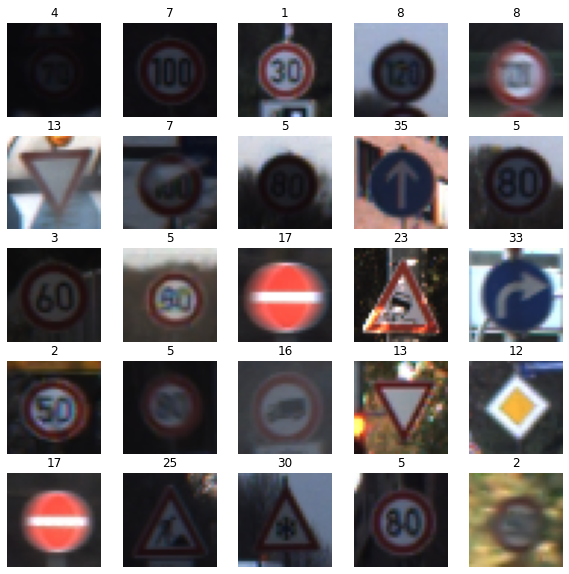

In [ ]:

# Visualizing traing batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

# **Building the model**

In [ ]:
# Setup input shape to the model
INPUT_SHAPE = [IMG_SIZE, IMG_SIZE, 3]

# Setup the output shape
OUTPUT_SHAPE = len(unique_signs)

In [ ]:
# Creating CNN Model
def traffic_sign_net(input_shape):
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(43, activation='softmax'))
    return model

In [ ]:
# Create a function that creates model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE):
    # Setup the model layers
    model = traffic_sign_net(input_shape=input_shape)
    # Compile the model
    print("Compiling the model")
    MyCnn=model.compile(
        loss = tf.keras.losses.CategoricalCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(),
        metrics = ["accuracy"]
    )
    return model

In [ ]:
MyCnn = create_model()
MyCnn.summary()


Compiling the model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 

In [ ]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)


# **Training our model**

In [ ]:
NUM_EPOCHS = 30

In [ ]:
model_saved = MyCnn.fit(x=train_data, 
                        validation_data=val_data,
                        validation_freq=1,
                        epochs = NUM_EPOCHS,
                        callbacks=[early_stopping] 
                        )

Epoch 1/30
491/491 [==============================] - 163s 330ms/step - loss: 1.7709 - accuracy: 0.5033 - val_loss: 0.2539 - val_accuracy: 0.9185
Epoch 2/30
491/491 [==============================] - 162s 330ms/step - loss: 0.3094 - accuracy: 0.9043 - val_loss: 0.0802 - val_accuracy: 0.9791
Epoch 3/30
491/491 [==============================] - 163s 332ms/step - loss: 0.1691 - accuracy: 0.9486 - val_loss: 0.0407 - val_accuracy: 0.9897
Epoch 4/30
491/491 [==============================] - 166s 338ms/step - loss: 0.1197 - accuracy: 0.9636 - val_loss: 0.0290 - val_accuracy: 0.9915
Epoch 5/30
491/491 [==============================] - 167s 339ms/step - loss: 0.0896 - accuracy: 0.9735 - val_loss: 0.0281 - val_accuracy: 0.9929
Epoch 6/30
491/491 [==============================] - 166s 338ms/step - loss: 0.0794 - accuracy: 0.9766 - val_loss: 0.0255 - val_accuracy: 0.9943
Epoch 7/30
491/491 [==============================] - 167s 340ms/step - loss: 0.0617 - accuracy: 0.9824 - val_loss: 0.0224 -

In [ ]:

MyCnn.save('mymodel.h5',model_saved)
print('model save successfully')

model save successfully


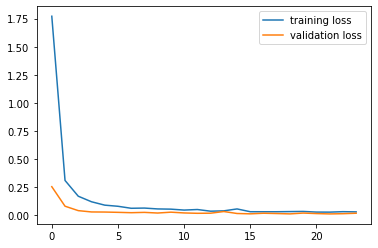

In [ ]:

plt.plot(model_saved.history['loss'], label = 'training loss')
plt.plot(model_saved.history['val_loss'], label = 'validation loss')
plt.legend()

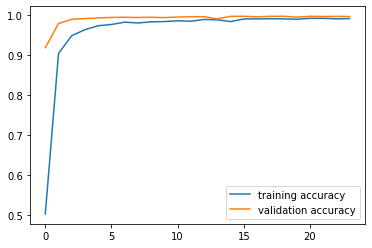

In [ ]:
plt.plot(model_saved.history['accuracy'], label = 'training accuracy')
plt.plot(model_saved.history['val_accuracy'], label = 'validation accuracy')
plt.legend()

# **Creating test dataset batches**


In [ ]:
test_df = pd.read_csv('/content/Test.csv')
test_df = test_df.drop(['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2'], axis=1)
test_df.head()

ClassId            Path
0       16  Test/00000.png
1        1  Test/00001.png
2       38  Test/00002.png
3       33  Test/00003.png
4       11  Test/00004.png

In [ ]:

test_img_paths = ['/content/' + path for path in test_df['Path']]
test_img_paths[:10]

['/content/Test/00000.png',
 '/content/Test/00001.png',
 '/content/Test/00002.png',
 '/content/Test/00003.png',
 '/content/Test/00004.png',
 '/content/Test/00005.png',
 '/content/Test/00006.png',
 '/content/Test/00007.png',
 '/content/Test/00008.png',
 '/content/Test/00009.png']

In [99]:

X_test = create_data_batches(test_img_paths, test_data=True)
y_test = list(test_df['ClassId'])
y_test[:10]

Creating test data batches...


[16, 1, 38, 33, 11, 38, 18, 12, 25, 35]

# **Making and Evaluating predictions using a trained model on test data**

In [100]:
model = Sequential()

In [101]:
predictions = model.predict(X_test, verbose=1)

198/198 [==============================] - 18s 89ms/step


In [163]:
j=(16, 1, 38, 33, 11, 38, 18, 12, 25, 35)

In [103]:

# Function to convert probabilities to labels
def get_pred_label(prediction_probabilities):
    """
    Turns an array of prediction probabilities into a label.
    """
    return unique_signs[np.argmax(prediction_probabilities)]

In [164]:
# Turning probabilities to labels
pred_labels = []
for i in predictions:
    pred_labels.append(get_pred_label(j))
pred_labels[:10]

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [165]:
# Getting the accuracy of the model on test data
acc = accuracy_score(y_test, pred_labels)
acc

0.05938242280285035

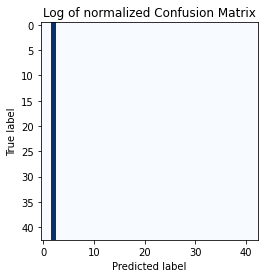

In [150]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,pred_labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.log(.0001 + cm)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Log of normalized Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [166]:
test = pd.read_csv( '/content/Test.csv')

labels = test["ClassId"].values
test_imgs = test["Path"].values

(1, 32, 32, 3)
33


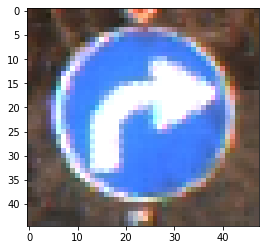

In [167]:
from PIL import Image
img_index = 108
image = Image.open('/content/' + test_imgs[img_index])
img = image.resize((32,32))
img = np.array(img)/255.
img = img.reshape(1,32,32,3)
print(img.shape)
print(labels[img_index])
plt.imshow(image)

In [168]:
#dictionary to label all traffic signs class.
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [172]:
pred = model.predict_classes(img)[0]
print(pred)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [176]:
sign = classes
print(sign)

{0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)', 3: 'Speed limit (60km/h)', 4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)', 6: 'End of speed limit (80km/h)', 7: 'Speed limit (100km/h)', 8: 'Speed limit (120km/h)', 9: 'No passing', 10: 'No passing veh over 3.5 tons', 11: 'Right-of-way at intersection', 12: 'Priority road', 13: 'Yield', 14: 'Stop', 15: 'No vehicles', 16: 'Veh > 3.5 tons prohibited', 17: 'No entry', 18: 'General caution', 19: 'Dangerous curve left', 20: 'Dangerous curve right', 21: 'Double curve', 22: 'Bumpy road', 23: 'Slippery road', 24: 'Road narrows on the right', 25: 'Road work', 26: 'Traffic signals', 27: 'Pedestrians', 28: 'Children crossing', 29: 'Bicycles crossing', 30: 'Beware of ice/snow', 31: 'Wild animals crossing', 32: 'End speed + passing limits', 33: 'Turn right ahead', 34: 'Turn left ahead', 35: 'Ahead only', 36: 'Go straight or right', 37: 'Go straight or left', 38: 'Keep right', 39: 'Keep left', 40: 'Roundabout man